# Required Installation and Library

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install fasttext lightgbm xgboost

: 

In [ ]:
!pip install -U transformers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import pandas as pd
from datasets import Dataset, load_dataset

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    AutoModelForSequenceClassification
)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, f1_score, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence


from collections import Counter
from datasets import Dataset
import fasttext


torch.manual_seed(42)
np.random.seed(42)

In [ ]:
%cd drive/MyDrive/RequiredFiles

/content/drive/MyDrive/RequiredFiles


In [ ]:
# loading fasttext khmer word embedding model
embedding_model = fasttext.load_model('cc.km.300.bin')

# Data Preprocessing

In [ ]:
df = pd.read_csv("train.csv", encoding='utf-8')

In [ ]:
df.shape

(20106, 4)

We will using our text file that contain Khmer sentences from ALT Parallel Corpus.

## Loading Dataset for LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset # Import Dataset from torch.utils.data
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class KhmerTextDataset(Dataset):
    """Dataset for LSTM training using FastText embeddings"""

    def __init__(self, tokens_list, labels, embedding_model):
        self.tokens_list = tokens_list
        self.labels = labels
        self.embedding_model = embedding_model
        self.embedding_dim = embedding_model.get_dimension()

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        # Handle single index
        tokens = self.tokens_list[idx]
        label = self.labels[idx]

        # Convert tokens to embeddings using FastText
        embeddings = []
        for token in tokens:
            try:
                vec = self.embedding_model.get_word_vector(token)
            except:
                vec = np.zeros(self.embedding_dim)
            embeddings.append(vec)

        # Convert to tensor directly from list of numpy arrays
        embeddings = torch.FloatTensor(embeddings)
        label = torch.LongTensor([label])

        return embeddings, label, len(tokens)


def collate_batch(batch):
    """Collate function for DataLoader with padding"""
    # batch is a list of tuples (embeddings, label, length)
    embeddings_list, labels_list, lengths_list = zip(*batch)

    # Pad the sequence of tensors
    padded_embeddings = pad_sequence(embeddings_list, batch_first=True)
    labels = torch.cat(labels_list) # Concatenate labels
    lengths = torch.LongTensor(lengths_list)

    return padded_embeddings, labels, lengths

# Word Tokenization/ POS Tagging



We perform work tokenization and POS Tagging by using a fine-tuned LLM called khmer-pos-roberta. https://huggingface.co/seanghay/khmer-pos-roberta  

In [ ]:
class KhmerPOSTagger:

    def __init__(self, model_name="seanghay/khmer-pos-roberta"):
        print(f"Loading POS tagger: {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForTokenClassification.from_pretrained(model_name)
        self.pipeline = pipeline(
            "token-classification",
            model=self.model,
            tokenizer=self.tokenizer,
            aggregation_strategy="simple"
        )

    def tag_sentence(self, sentence):
        try:
            tags = self.pipeline(sentence)
            tokens = [t["word"] for t in tags]
            pos_tags = [t["entity_group"] for t in tags]
            return tokens, pos_tags
        except Exception as e:
            print(f"⚠ POS tagging error for sentence: {sentence[:50]}... Error: {e}")
            return [], []

    def tag_dataframe(self, df, text_column='text'):
        print(f"Tagging {len(df)} sentences...")

        tokens_list = []
        pos_tags_list = []

        for sentence in tqdm(df[text_column], desc="POS Tagging"):
            tokens, pos_tags = self.tag_sentence(sentence)
            tokens_list.append(tokens)
            pos_tags_list.append(pos_tags)

        # Add as separate columns
        df['tokens'] = tokens_list
        df['pos_tags'] = pos_tags_list

        print(f"✓ POS tagging complete")
        print(f"✓ Added 'tokens' column")
        print(f"✓ Added 'pos_tags' column")

        return df

# Feature Extraction

For feature extraction, we will extract
*   OOV (Out-of Vocabulary) score to measure
1. oov_ratio - OOV ratio
---
*   Grammar Score (using dependency parsing)
1.  grammar_score - Grammar score
2.  has_complete_clause - Has SVO structure

---
*   Text Based Feature (sentence length, POS diversity,...)

1.  grammar_oov_interaction - Combined score
2.   pos_diversity - POS tag variety
3.   sentence_length - Number of words

---

*   quality_indicator - Simple heuristic




## OOV-Feature (Out of Vocabulary)

In [ ]:

class EmbeddingOOVCalculator:
    def __init__(self, embedding_model=None):
        """Initialize with an embedding model"""
        self.embedding_model = embedding_model
        self.vocab = set()

        if embedding_model:
            self._load_vocab_from_model()

    def _load_vocab_from_model(self):
        """Extract vocabulary from embedding model"""
        try:
            # Try FastText/Word2Vec style (Gensim) - Removed
            # Try custom get_words() method (FastText)
            if hasattr(self.embedding_model, 'get_words'):
                self.vocab = set(self.embedding_model.get_words())
            # Try direct key_to_index - Removed
            else:
                raise AttributeError("Model doesn't have recognized vocabulary interface")

            print(f"✓ Loaded {len(self.vocab):,} words from embedding model")
        except Exception as e:
            print(f"✗ Error loading vocabulary from model: {e}")

    def is_in_vocabulary(self, word):
        """Check if word is in embedding vocabulary"""
        # Check if word is in fasttext vocabulary
        return word.strip() in self.vocab

    def calculate_oov_ratio(self, tokens):
        """Calculate OOV ratio for tokens"""
        if isinstance(tokens, str):
            words = tokens.split()
        else:
            words = tokens

        if not words:
            return 0.0

        oov_count = sum(1 for word in words if not self.is_in_vocabulary(word))
        return oov_count / len(words)

    def calculate_oov_details(self, tokens):
        """Get detailed OOV information with word classifications"""
        if isinstance(tokens, str):
            words = tokens.split()
        else:
            words = tokens

        oov_words = []
        known_words = []

        for word in words:
            if self.is_in_vocabulary(word):
                known_words.append(word)
            else:
                oov_words.append(word)

        return {
            'total_words': len(words),
            'known_words': len(known_words),
            'oov_words': len(oov_words),
            'oov_ratio': len(oov_words) / max(len(words), 1),
            'oov_word_list': oov_words,
            'known_word_list': known_words,
            'vocabulary_coverage': len(known_words) / max(len(words), 1)
        }

    def add_oov_features(self, df, text_col='tokens'):
        """Add OOV features to DataFrame"""
        df = df.copy()

        print(f"Calculating OOV features for {len(df):,} texts...")

        oov_ratios = []
        vocab_coverages = []
        from tqdm.auto import tqdm

        for i, row in tqdm(df.iterrows(), total=len(df), desc="OOV Analysis"):
            text = row[text_col]
            details = self.calculate_oov_details(text)
            oov_ratios.append(details['oov_ratio'])
            vocab_coverages.append(details['vocabulary_coverage'])


        df['oov_ratio'] = oov_ratios
        df['vocab_coverage'] = vocab_coverages

        print(f"\n✓ OOV features extracted")
        print(f"  Mean OOV ratio: {df['oov_ratio'].mean():.3f}")
        print(f"  Mean vocab coverage: {df['vocab_coverage'].mean():.3f}")
        print(f"  Median OOV ratio: {df['oov_ratio'].median():.3f}")
        print(f"  Max OOV ratio: {df['oov_ratio'].max():.3f}")

        return df

    def extract_unknown_words(self, df, text_col='tokens', output_file='unknown_words.csv'):
        """Extract all unique unknown words with frequencies"""
        print("Extracting unknown words...")

        unknown_words = []
        from tqdm.auto import tqdm

        for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting Unknown Words"):
            text = row[text_col]
            details = self.calculate_oov_details(text)
            unknown_words.extend(details['oov_word_list'])

        word_counts = Counter(unknown_words)

        unknown_df = pd.DataFrame([
            {'word': word, 'frequency': count}
            for word, count in word_counts.most_common()
        ])

        print(f"\n✓ Found {len(unknown_df):,} unique unknown words")
        if len(unknown_df) > 0:
            print(f"  Total occurrences: {sum(unknown_df['frequency']):,}")

        if output_file and len(unknown_df) > 0:
            unknown_df.to_csv(output_file, index=False, encoding='utf-8')
            print(f"✓ Saved to {output_file}")

        if len(unknown_df) > 0:
            print(f"\nTop 20 most frequent unknown words:")
            print(unknown_df.head(20).to_string(index=False))

        return unknown_df

    def evaluate_text_quality(self, text):
        """Evaluate Khmer text quality (for grammar/vocab checking)"""
        details = self.calculate_oov_details(text)

        # Quality scoring
        vocab_score = details['vocabulary_coverage'] * 100

        # Categorize quality
        if vocab_score >= 95:
            quality = "Excellent"
            message = "ល្អប្រសើរ - Vocabulary is excellent"
        elif vocab_score >= 85:
            quality = "Good"
            message = "ល្អ - Good vocabulary usage"
        elif vocab_score >= 70:
            quality = "Fair"
            message = "មធ្យម - Some vocabulary issues detected"
        else:
            quality = "Poor"
            message = "ខ្សោយ - Many unknown words detected"

        result = {
            'quality': quality,
            'vocab_score': vocab_score,
            'message': message,
            'total_words': details['total_words'],
            'known_words': details['known_words'],
            'unknown_words': details['oov_words'],
            'unknown_word_list': details['oov_word_list']
        }

        return result

## Grammar Score Feature






In [ ]:
class SimplePOSGrammarExtractor:

    @staticmethod
    def calculate_grammar_score(pos_tags):

        if len(pos_tags) < 2:
            return 0.5

        score = 0.5  # Base score

        # Check for complete clause (SVO structure)
        has_subject = any(tag.startswith('NN') for tag in pos_tags)
        has_verb = any(tag.startswith('VB') for tag in pos_tags)
        has_object = len([tag for tag in pos_tags if tag.startswith('NN')]) > 1

        if has_subject and has_verb:
            score += 0.3
        if has_object:
            score += 0.2

        return min(score, 1.0)

    @staticmethod
    def has_complete_clause(pos_tags):
        """
        Enhanced complete clause detection for mid-average to complex sentences

        Checks for:
        1. Basic SVO: Subject (NN) + Verb (VB)
        2. Passive constructions: Verb + Subject
        3. Auxiliary verbs: AUX + main verb
        4. Existential constructions: There/Here + Verb
        5. Imperative sentences: Verb only (subject implied)
        6. Complex clauses: Multiple verbs with proper structure

        Returns 1 if sentence has complete clause structure, 0 otherwise
        """
        if not pos_tags or len(pos_tags) == 0:
            return 0

        # Count key POS elements
        has_noun = any(tag.startswith('NN') or tag.startswith('PR') for tag in pos_tags)
        has_verb = any(tag.startswith('VB') or tag == 'AUX' for tag in pos_tags)
        has_aux = any(tag == 'AUX' for tag in pos_tags)

        # Pattern 1: Standard SVO (Subject + Verb)
        if has_noun and has_verb:
            return 1

        # Pattern 2: Imperative sentences (Verb without explicit subject)
        # Khmer allows subject-drop in commands: "ទៅ!" (Go!)
        if has_verb and len(pos_tags) >= 1:
            # Check if starts with verb (imperative pattern)
            if pos_tags[0].startswith('VB'):
                return 1

            # Check if has verb + object pattern (V + NN)
            for i in range(len(pos_tags) - 1):
                if pos_tags[i].startswith('VB') and pos_tags[i+1].startswith('NN'):
                    return 1

        # Pattern 3: Existential/Copula constructions
        # "នៅ + NN" (There is/are + noun) or "គឺ + NN" (is + noun)
        existential_markers = {'VB', 'AUX', 'CC'}
        has_existential = any(tag in existential_markers for tag in pos_tags)
        if has_existential and has_noun:
            return 1

        # Pattern 4: Question patterns (may have inverted structure)
        # Questions can have verb before subject in Khmer
        if 'WP' in pos_tags or 'WDT' in pos_tags or 'WRB' in pos_tags:
            # Has question word + verb
            if has_verb:
                return 1

        # Pattern 5: Complex sentences with conjunctions
        # Multiple clauses connected by CC (coordinating conjunction)
        if 'CC' in pos_tags and has_verb:
            # Has conjunction + verb (likely compound sentence)
            return 1

        # Pattern 6: Auxiliary + Main Verb construction
        # "កំពុង + VB" (is + verb-ing) or "នឹង + VB" (will + verb)
        if has_aux:
            # Has auxiliary verb (implies complete predicate)
            return 1

        # Pattern 7: Relative clause structures
        # Sentences with relative pronouns and verbs
        if any(tag.startswith('WP') or tag == 'WDT' for tag in pos_tags) and has_verb:
            return 1

        # Pattern 8: Check for verb chain (multiple verbs in sequence)
        # Khmer allows serial verb constructions: "ទៅ ញ៉ាំ បាយ" (go eat rice)
        verb_count = sum(1 for tag in pos_tags if tag.startswith('VB') or tag == 'AUX')
        if verb_count >= 2:
            # Serial verb construction (complete in Khmer)
            return 1

        # Pattern 9: Predicate adjective constructions
        # "NN + JJ" can form complete sentence in Khmer: "បាយ ឆ្ងាញ់" (rice delicious)
        has_adj = any(tag.startswith('JJ') for tag in pos_tags)
        if has_noun and has_adj and len(pos_tags) >= 2:
            # Check if noun + adjective pattern exists
            for i in range(len(pos_tags) - 1):
                if pos_tags[i].startswith('NN') and pos_tags[i+1].startswith('JJ'):
                    return 1

        # Pattern 10: Fragment detection - definitely incomplete
        # Only has nouns or only has verbs (but not both)
        only_nouns = has_noun and not has_verb and not has_adj
        only_verbs = has_verb and not has_noun and len(pos_tags) < 2

        if only_nouns or only_verbs:
            return 0

        # Default: If has verb (most basic completeness check)
        return 1 if has_verb else 0

    def extract_features(self, df):

        print("Extracting simple POS-based grammar features...")

        df['dep_grammar_score'] = df['pos_tags'].apply(self.calculate_grammar_score)
        df['has_complete_clause'] = df['pos_tags'].apply(self.has_complete_clause)

        print(f"✓ Simple grammar features extracted")
        print(f"  Mean grammar score: {df['dep_grammar_score'].mean():.3f}")
        print(f"  Complete clauses: {df['has_complete_clause'].sum()} / {len(df)} ({df['has_complete_clause'].mean()*100:.1f}%)")

        return df


## Grammar/OOV Interaction Score


Feature 1: Grammar-OOV Interaction (MOST IMPORTANT)
Formula: interaction = grammar_score × (1 - oov_ratio)
Range: [0, 1]

Mathematical interpretation:
- High grammar × Low OOV = High score (likely RIGHT)
- Low grammar × High OOV = Low score (likely WRONG)
- High grammar × High OOV = Medium score (RIGHT GRAMMAR, WRONG VOCAB)
- Low grammar × Low OOV = Medium score (RIGHT VOCAB, WRONG GRAMMAR)

Detailed calculation examples:
Example 1: Entirely Correct Sentence
- grammar_score = 0.95
- oov_ratio = 0.0
- interaction = 0.95 × (1 - 0.0) = 0.95 × 1.0 = 0.95 ✓


Example 2: Entirely Wrong Sentence
- grammar_score = 0.3
- oov_ratio = 0.8
- interaction = 0.3 × (1 - 0.8) = 0.3 × 0.2 = 0.06 ✗


Example 3: Right Grammar, Wrong Vocabulary
- grammar_score = 0.9
- oov_ratio = 0.6
- interaction = 0.9 × (1 - 0.6) = 0.9 × 0.4 = 0.36


Example 4: Wrong Grammar, Right Vocabulary
- grammar_score = 0.4
- oov_ratio = 0.1
- interaction = 0.4 × (1 - 0.1) = 0.4 × 0.9 = 0.36


In [ ]:
class InteractionFeatureExtractor:
    @staticmethod
    def calculate_grammar_oov_interaction(grammar_score, oov_ratio):

        return grammar_score * (1 - oov_ratio)

    def extract_features(self, df):
        """Add interaction features to dataframe"""
        print("Calculating interaction features...")
        df['grammar_oov_interaction'] = df.apply(
            lambda row: self.grammar_oov_interaction(
                row['grammar_score'],
                row['oov_ratio']
            ),
            axis=1
        )
        print(f"✓ Interaction features extracted")
        return df

## Text-based feature

Here we apply length to each tokens rows to get the amount of tokens corresponding to the complexity of the sentences based of the sentence lenght.

*italicized text*### Sentence Length/ Average Word Length/ Char Per Word Ratio

In [ ]:
class TextFeatureExtractor:
    @staticmethod
    def calculate_sentence_length(tokens):
        """
        Calculate sentence length based on the number of tokens.
        """
        return len(tokens)


    @staticmethod
    def calculate_avg_word_length(tokens):
        """

        Formula: avg_length = total_characters / num_words

        Calculation example:
        Sentence: "កុមារ ទៅ សាលា"
        Word lengths: [5, 3, 5] characters
        Average: (5 + 3 + 5) / 3 = 4.33

        Khmer linguistic note:
        - Typical Khmer word: 3-6 characters
        - Very short words (1-2 chars): Often particles or determiners
        - Long words (> 8 chars): Often compound words or formal terms

        """
        if not tokens:
            return 0.0

        total_chars = sum(len(word) for word in tokens)
        return total_chars / len(tokens)

    @staticmethod
    def calculate_char_per_word_ratio(tokens):
      """

      Formula: ratio = total_chars / num_words
      (Similar to avg_word_length but provides different scale)

      """
      if not tokens:
          return 0.0

      total_chars = sum(len(word) for word in tokens)


      return total_chars / len(tokens)

    @staticmethod
    def calculate_pos_diversity(pos_tags):
        """
        Calculate POS diversity based on the number of unique POS tags
        divided by the total number of tokens.
        """
        if not pos_tags:
            return 0.0
        unique_pos_tags = set(pos_tags)
        return len(unique_pos_tags) / len(pos_tags)


    @staticmethod
    def extract_all_text_features(sentence, tokens):
        """
        Extract all text features at once.
        Takes both the original sentence string and the list of tokens.
        """
        return {
            'sentence_length': TextFeatureExtractor.calculate_sentence_length(tokens),
            'avg_word_length': TextFeatureExtractor.calculate_avg_word_length(tokens),
            'char_per_word': TextFeatureExtractor.calculate_char_per_word_ratio(tokens)
        }

In [ ]:
# The dependency parsing functions (calculate_dependency_grammar_score, has_complete_clause_advanced,
# extract_vital_dependency_features, parse_sentence_with_dependency) and their associated logic are removed
# as the user requested to use the simple method and eliminate Stanza-related code.

# This function is now simplified to always use the SimplePOSGrammarExtractor.
# def extract_grammar_features(df):
#     """
#     Extracts grammar features using SimplePOSGrammarExtractor.
#     Dependency parsing is no longer used.
#     """
#     print("Calculating grammar features using simple POS-based method...")

#     # Initialize simple extractor
#     simple_extractor = SimplePOSGrammarExtractor()

#     # Use simple POS-based features via class
#     df = simple_extractor.extract_features(df)

#     print(f"✓ Simple grammar features extracted")
#     print(f"  Mean grammar score: {df['dep_grammar_score'].mean():.3f}")
#     print(f"  Complete clauses: {df['has_complete_clause'].sum()} / {len(df)} ({df['has_complete_clause'].mean()*100:.1f}%)")

#     return df

## Language Model Score

Using word embedding to capture semantic relationship between word to see if the context of each word in the sentence is related to one another or not.

In [ ]:
class SemanticCoherence:
    CONTENT_POS = {'NN', 'VB', 'JJ', 'RB', 'CD'}

    POS_WEIGHTS = {
        ("NN", "VB"): 1.5,
        ("VB", "NN"): 1.5,
        ("JJ", "NN"): 1.2,
        ("NN", "NN"): 1.0,
        ("VB", "VB"): 1.0,
        ("RB", "VB"): 0.8,
    }

    def __init__(self, embedding_model):
        self.embedding_model = embedding_model
        self.dim = embedding_model.get_dimension()

    def get_vector(self, word):
            """Get word vector, return zero vector if not found"""
            try:
                return self.embedding_model.get_word_vector(word)
            except:
                return np.zeros(self.dim)

    def weighted_semantic_coherence(self, tokens, pos_tags):
        """Calculate weighted coherence based on POS relationships"""
        if len(tokens) < 2:
            return 0.5

        scores = []
        weights = []

        for i in range(len(tokens) - 1):
            current_pos = pos_tags[i]
            next_pos = pos_tags[i + 1]
            weight = self.POS_WEIGHTS.get((current_pos, next_pos), 0.5)

            if weight > 0:
                v1 = self.get_vector(tokens[i])
                v2 = self.get_vector(tokens[i + 1])
                sim = cosine_similarity([v1], [v2])[0][0]
                scores.append(sim)
                weights.append(weight)

        if not scores:
            return 0.0

        return np.average(scores, weights=weights)


    def content_word_coherence(self, tokens, pos_tags):
      """Calculate coherence using only content words"""
      content_tokens = [tokens[i] for i in range(len(tokens))
                        if pos_tags[i] in self.CONTENT_POS]

      if len(content_tokens) < 2:
          return 0.5

      scores = []
      for i in range(len(content_tokens) - 1):
          v1 = self.get_vector(content_tokens[i])
          v2 = self.get_vector(content_tokens[i + 1])
          sim = cosine_similarity([v1], [v2])[0][0]
          scores.append(sim)

      return np.mean(scores)


    def multi_distance_coherence(self, tokens, max_distance=3):
            """Calculate coherence across multiple word distances"""
            all_scores = []

            for distance in range(1, min(max_distance + 1, len(tokens))):
                for i in range(len(tokens) - distance):
                    v1 = self.get_vector(tokens[i])
                    v2 = self.get_vector(tokens[i + distance])
                    sim = cosine_similarity([v1], [v2])[0][0]
                    weighted_sim = sim / distance
                    all_scores.append(weighted_sim)

            return np.mean(all_scores) if all_scores else 0.0

    def ensemble_coherence_score(self, tokens, pos_tags):
        """Combine multiple coherence methods"""
        if len(tokens) < 2:
            return 0.5

        s1 = self.weighted_semantic_coherence(tokens, pos_tags)
        s2 = self.content_word_coherence(tokens, pos_tags)
        s3 = self.multi_distance_coherence(tokens)

        # Weighted ensemble
        return 0.4 * s1 + 0.3 * s2 + 0.3 * s3

    def extract_features(self, df):
      """Add semantic coherence features to dataframe"""
      print("Calculating semantic coherence features...")

      coherence_scores = []
      from tqdm.auto import tqdm
      for _, row in tqdm(df.iterrows(), total=len(df), desc="Semantic Analysis"):
          score = self.ensemble_coherence_score(row['tokens'], row['pos_tags'])
          coherence_scores.append(score)

      df['semantic_coherence'] = coherence_scores
      print(f"✓ Semantic coherence extracted")
      print(f"  Mean coherence: {df['semantic_coherence'].mean():.3f}")
      return df

## Initalizing Feature Extraction Pipeline

In [ ]:
class FeaturePipeline:

    def __init__(self, embedding_model_path):
        self.embedding_model = fasttext.load_model(embedding_model_path)

        self.pos_tagger = KhmerPOSTagger()
        self.oov_extractor = EmbeddingOOVCalculator(self.embedding_model)
        # Initialize SimplePOSGrammarExtractor directly
        self.grammar_extractor = SimplePOSGrammarExtractor()
        self.semantic_extractor = SemanticCoherence(self.embedding_model)
        self.text_extractor = TextFeatureExtractor()
        self.interaction_extractor = InteractionFeatureExtractor()

    def extract_all_features(self, df):
        # Ensure 'text' column exists before POS tagging
        if 'text' not in df.columns:
            raise ValueError("DataFrame must contain a 'text' column for POS tagging.")

        df = self.pos_tagger.tag_dataframe(df)
        df = self.oov_extractor.add_oov_features(df)

        # Call the extract_features method on the grammar_extractor instance
        df = self.grammar_extractor.extract_features(df)


        # Apply text feature extraction row-wise
        print("Calculating text features...")
        text_features = df.apply(lambda row: self.text_extractor.extract_all_text_features(row['text'], row['tokens']), axis=1)
        text_features_df = pd.DataFrame(list(text_features))
        df = pd.concat([df, text_features_df], axis=1)

        # Calculate POS diversity
        df['pos_diversity'] = df['pos_tags'].apply(self.text_extractor.calculate_pos_diversity)
        print("✓ Text features extracted (including POS diversity)")


        df = self.semantic_extractor.extract_features(df)

        df['grammar_oov_interaction'] = df.apply(
            lambda row: self.interaction_extractor.calculate_grammar_oov_interaction(
                row.get('dep_grammar_score', 1.0), # Use dep_grammar_score
                row['oov_ratio']
            ),
            axis=1
        )
        print(f"✓ Interaction features extracted")


        return df # Return the updated dataframe

    @staticmethod # Added @staticmethod decorator
    def get_feature_cols():

        return [
            'oov_ratio',
            'dep_grammar_score',
            'has_complete_clause',
            'sentence_length',
            'avg_word_length',
            'char_per_word',
            'pos_diversity',
            'semantic_coherence',
            'grammar_oov_interaction'
        ]

In [ ]:
df.head(5)

,text,tokens,pos_tags,sentence_correct
0,អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃ...,"['អ៊ីតាលី', 'បាន', 'ឈ្នះ', 'លើ', 'ព័រទុយហ្គាល់...","['PN', 'AUX', 'VB', 'IN', 'PN', 'CD', 'IN', 'N...",1
1,បាន ស៊ុត នាទីទី ដំបូង ពាក់កណ្តាល សំរាប់ អ៊ីតាលី,"['បាន', 'ស៊ុត', 'នាទីទី', 'ដំបូង', 'ពាក់កណ្តាល...","['AUX', 'VB', 'NN', 'JJ', 'JJ', 'IN', 'PN']",0
2,ទោះបី បាន គ្រប់គ្រង ក្នុង គ្រា នៃ វគ្គ ពាក់កណ្...,"['ទោះបី', 'បាន', 'គ្រប់គ្រង', 'ក្នុង', 'គ្រា',...","['CC', 'AUX', 'VB', 'IN', 'NN', 'IN', 'NN', 'J...",0
3,ដក ថ ហើយ ដេវីតផេណាលវ៉ា បាន ស៊ុត ចូល ក្នងនាទីទី...,"['ដក', 'ថ', 'ហើយ', 'ដេវីតផេណាលវ៉ា', 'បាន', 'ស៊...","['VB', 'JJ', 'RB', 'PN', 'AUX', 'VB', 'PA', 'N...",0
4,អ៊ីតាលី 16-5 បាន នាំមុខ វគ្គ ដំបូង ព័រទុយហ្គាល...,"['អ៊ីតាលី', '16-5', 'បាន', 'នាំមុខ', 'វគ្គ', '...","['PN', 'CD', 'AUX', 'VB', 'NN', 'JJ', 'PN', 'NN']",0


# Data Spliting

## Feature Application

When training the model, this cell should be run to extract the feature.

In [ ]:
# # Load the training data
# df = pd.read_csv("train.csv", encoding='utf-8-sig')
# display(df.head())

# feature_pipeline = FeaturePipeline('cc.km.300.bin')

# # Extract all features
# df = feature_pipeline.extract_all_features(df)

# # Display the DataFrame with new feature columns
# display(df.head())

# # Save the DataFrame with applied features
# df.to_csv("train_data.csv", index=False, encoding='utf-8-sig')
# print("DataFrame with applied features saved to train_data.csv")

,text,tokens,pos_tags,sentence_correct
0,អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃ...,"['អ៊ីតាលី', 'បាន', 'ឈ្នះ', 'លើ', 'ព័រទុយហ្គាល់...","['PN', 'AUX', 'VB', 'IN', 'PN', 'CD', 'IN', 'N...",1
1,បាន ស៊ុត នាទីទី ដំបូង ពាក់កណ្តាល សំរាប់ អ៊ីតាលី,"['បាន', 'ស៊ុត', 'នាទីទី', 'ដំបូង', 'ពាក់កណ្តាល...","['AUX', 'VB', 'NN', 'JJ', 'JJ', 'IN', 'PN']",0
2,ទោះបី បាន គ្រប់គ្រង ក្នុង គ្រា នៃ វគ្គ ពាក់កណ្...,"['ទោះបី', 'បាន', 'គ្រប់គ្រង', 'ក្នុង', 'គ្រា',...","['CC', 'AUX', 'VB', 'IN', 'NN', 'IN', 'NN', 'J...",0
3,ដក ថ ហើយ ដេវីតផេណាលវ៉ា បាន ស៊ុត ចូល ក្នងនាទីទី...,"['ដក', 'ថ', 'ហើយ', 'ដេវីតផេណាលវ៉ា', 'បាន', 'ស៊...","['VB', 'JJ', 'RB', 'PN', 'AUX', 'VB', 'PA', 'N...",0
4,អ៊ីតាលី 16-5 បាន នាំមុខ វគ្គ ដំបូង ព័រទុយហ្គាល...,"['អ៊ីតាលី', '16-5', 'បាន', 'នាំមុខ', 'វគ្គ', '...","['PN', 'CD', 'AUX', 'VB', 'NN', 'JJ', 'PN', 'NN']",0


Loading POS tagger: seanghay/khmer-pos-roberta...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Device set to use cuda:0


✓ POS tagger loaded successfully
✓ Loaded 248,316 words from embedding model
Tagging 20106 sentences...


POS Tagging:   0%|          | 0/20106 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 20,106 texts...


OOV Analysis:   0%|          | 0/20106 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.223
  Mean vocab coverage: 0.777
  Median OOV ratio: 0.214
  Max OOV ratio: 0.833
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 0.983
  Complete clauses: 19994 / 20106 (99.4%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/20106 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.186
✓ Interaction features extracted


,text,tokens,pos_tags,sentence_correct,oov_ratio,vocab_coverage,dep_grammar_score,has_complete_clause,sentence_length,avg_word_length,char_per_word,pos_diversity,semantic_coherence,grammar_oov_interaction
0,អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃ...,"[អ៊ីតាលី, បាន, ឈ្នះ, លើ, ព័រទុយហ្គាល់, 31-5, ក...","[PN, AUX, VB, IN, PN, CD, IN, NN, PN, IN, NN, ...",1,0.217391,0.782609,1.0,1,23,5.956522,5.956522,0.391304,0.093762,0.782609
1,បាន ស៊ុត នាទីទី ដំបូង ពាក់កណ្តាល សំរាប់ អ៊ីតាលី,"[បាន, ស៊ុត នាទីទី, ដំបូង ពាក់កណ្តាល, សំរាប់, អ...","[AUX, NN, JJ, IN, PN]",0,0.400000,0.600000,0.5,1,5,8.600000,8.600000,1.000000,0.239242,0.300000
2,ទោះបី បាន គ្រប់គ្រង ក្នុង គ្រា នៃ វគ្គ ពាក់កណ្...,"[ទោះបី, បាន, គ្រប់គ្រង, ក្នុង, គ្រា, នៃ, វគ្គ,...","[CC, AUX, VB, IN, NN, IN, NN, JJ, RB, PN, RB, ...",0,0.153846,0.846154,1.0,1,26,5.423077,5.423077,0.384615,0.138355,0.846154
3,ដក ថ ហើយ ដេវីតផេណាលវ៉ា បាន ស៊ុត ចូល ក្នងនាទីទី...,"[ដក, ថ, ហើយ, ដេវីតផេណាលវ៉ា, បាន, ស៊ុ, ត, ចូល, ...","[VB, PN, RB, PN, AUX, NN, VB, PA, NN, IN, NN, ...",0,0.208333,0.791667,1.0,1,24,3.625000,3.625000,0.541667,0.152236,0.791667
4,អ៊ីតាលី 16-5 បាន នាំមុខ វគ្គ ដំបូង ព័រទុយហ្គាល...,"[អ៊ីតាលី, 16-5, បាន, នាំមុខ, វគ្គ, ដំបូង, ព័រទ...","[PN, CD, AUX, VB, NN, JJ, PN, NN]",0,0.125000,0.875000,1.0,1,8,5.625000,5.625000,0.750000,0.130946,0.875000


DataFrame with applied features saved to train_data.csv


In [ ]:
display(df.head(5))

,text,tokens,pos_tags,sentence_correct,oov_ratio,vocab_coverage,dep_grammar_score,has_complete_clause,sentence_length,avg_word_length,char_per_word,pos_diversity,semantic_coherence,grammar_oov_interaction
0,អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃ...,"[អ៊ីតាលី, បាន, ឈ្នះ, លើ, ព័រទុយហ្គាល់, 31-5, ក...","[PN, AUX, VB, IN, PN, CD, IN, NN, PN, IN, NN, ...",1,0.217391,0.782609,1.0,1,23,5.956522,5.956522,0.391304,0.093762,0.782609
1,បាន ស៊ុត នាទីទី ដំបូង ពាក់កណ្តាល សំរាប់ អ៊ីតាលី,"[បាន, ស៊ុត នាទីទី, ដំបូង ពាក់កណ្តាល, សំរាប់, អ...","[AUX, NN, JJ, IN, PN]",0,0.400000,0.600000,0.5,1,5,8.600000,8.600000,1.000000,0.239242,0.300000
2,ទោះបី បាន គ្រប់គ្រង ក្នុង គ្រា នៃ វគ្គ ពាក់កណ្...,"[ទោះបី, បាន, គ្រប់គ្រង, ក្នុង, គ្រា, នៃ, វគ្គ,...","[CC, AUX, VB, IN, NN, IN, NN, JJ, RB, PN, RB, ...",0,0.153846,0.846154,1.0,1,26,5.423077,5.423077,0.384615,0.138355,0.846154
3,ដក ថ ហើយ ដេវីតផេណាលវ៉ា បាន ស៊ុត ចូល ក្នងនាទីទី...,"[ដក, ថ, ហើយ, ដេវីតផេណាលវ៉ា, បាន, ស៊ុ, ត, ចូល, ...","[VB, PN, RB, PN, AUX, NN, VB, PA, NN, IN, NN, ...",0,0.208333,0.791667,1.0,1,24,3.625000,3.625000,0.541667,0.152236,0.791667
4,អ៊ីតាលី 16-5 បាន នាំមុខ វគ្គ ដំបូង ព័រទុយហ្គាល...,"[អ៊ីតាលី, 16-5, បាន, នាំមុខ, វគ្គ, ដំបូង, ព័រទ...","[PN, CD, AUX, VB, NN, JJ, PN, NN]",0,0.125000,0.875000,1.0,1,8,5.625000,5.625000,0.750000,0.130946,0.875000


In [ ]:
# # Select features (X) and target (y)
# feature_columns = feature_pipeline.get_feature_cols()
# # Filter out 'pos_diversity' if it's not yet implemented in the pipeline
# feature_columns = [col for col in feature_columns if col in df.columns]

# X = df[feature_columns]
# y = df['sentence_correct'] # Assuming 'sentence_correct' is the target column

# # Split data into training, validation, and test sets
# X_temp, X_test, y_temp, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
# )

# print(f"Train set: {len(X_train)} samples")
# print(f"Validation set: {len(X_val)} samples")
# print(f"Test set: {len(X_test)} samples")

Train set: 12063 samples
Validation set: 4021 samples
Test set: 4022 samples


# Uncomment Here

In [ ]:
df = pd.read_csv("train_data.csv", encoding="utf-8-sig")
df.head(5)

X = df[[
            'oov_ratio',
            'dep_grammar_score',
            'has_complete_clause',
            'sentence_length',
            'avg_word_length',
            'char_per_word',
            'pos_diversity',
            'semantic_coherence',
            'grammar_oov_interaction'
        ]]

y = df['sentence_correct']

# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

## Scaling

In [ ]:
# Scale features for non-LSTM models (LSTM uses embeddings directly)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## Dataset for LSTM

In [ ]:
if 'tokens' not in df.columns:
    print("Error: 'tokens' column not found in the dataframe. Ensure FeaturePipeline was run correctly.")
else:
    train_dataset = KhmerTextDataset(
        # Use tokens from the original df before splitting, indexing with the split indices
        df.loc[X_train.index, 'tokens'].tolist(),
        y_train.values,
        embedding_model # Use the loaded embedding model
    )
    val_dataset = KhmerTextDataset(
        df.loc[X_val.index, 'tokens'].tolist(),
        y_val.values,
        embedding_model
    )
    test_dataset = KhmerTextDataset(
        df.loc[X_test.index, 'tokens'].tolist(),
        y_test.values,
        embedding_model
    )

    # Here we replace df.loc with trained_df.loc because we are using the pre-extracted dataset

    print(f"KhmerTextDataset created for train, validation, and test sets.")
    print(f"Train Dataset size: {len(train_dataset)}")
    print(f"Validation Dataset size: {len(val_dataset)}")
    print(f"Test Dataset size: {len(test_dataset)}")

KhmerTextDataset created for train, validation, and test sets.
Train Dataset size: 12063
Validation Dataset size: 4021
Test Dataset size: 4022


# Model Development

## Logistic Regression/ Random Forest/ Gradient Boosting/ Naive Bayes

In [ ]:
class ModelTrainer:
    """Train and evaluate classification models"""

    def __init__(self):
        self.models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'Naive Bayes': GaussianNB()
        }
        self.scaler = StandardScaler()
        self.best_model = None
        self.best_model_name = None
        self.results = {}

    def prepare_data(self, df, feature_columns, target_column='sentence_correct'):
        """Split and scale data"""
        print("\n" + "="*80)
        print("DATA PREPARATION")
        print("="*80)

        X = df[feature_columns]
        y = df[target_column]

        # First split: 80% train+val, 20% test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Second split: 75% train, 25% val (of the 80%)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"✓ Train set: {len(X_train)} samples")
        print(f"✓ Validation set: {len(X_val)} samples")
        print(f"✓ Test set: {len(X_test)} samples")
        print(f"✓ Features scaled using StandardScaler\n")

        return {
            'X_train': X_train_scaled,
            'X_val': X_val_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test
        }

    def train_models(self, data):
        """Train all models and evaluate on validation set"""
        print("="*80)
        print("MODEL TRAINING")
        print("="*80 + "\n")

        for name, model in self.models.items():
            print(f"\n{'-'*80}")
            print(f"Training: {name}")
            print('-'*80)

            # Train
            model.fit(data['X_train'], data['y_train'])

            # Predict on validation set
            y_val_pred = model.predict(data['X_val'])

            # Calculate metrics
            accuracy = accuracy_score(data['y_val'], y_val_pred)
            precision = precision_score(data['y_val'], y_val_pred, average='binary')
            recall = recall_score(data['y_val'], y_val_pred, average='binary')
            f1 = f1_score(data['y_val'], y_val_pred, average='binary')

            self.results[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'predictions': y_val_pred
            }

            print(f"Validation Accuracy:  {accuracy:.4f}")
            print(f"Validation Precision: {precision:.4f}")
            print(f"Validation Recall:    {recall:.4f}")
            print(f"Validation F1-Score:  {f1:.4f}")

        # Select best model
        self.best_model_name = max(self.results.keys(),
                                   key=lambda k: self.results[k]['f1'])
        self.best_model = self.results[self.best_model_name]['model']

        print(f"\n{'='*80}")
        print(f"BEST MODEL: {self.best_model_name}")
        print(f"F1-Score: {self.results[self.best_model_name]['f1']:.4f}")
        print('='*80 + "\n")

        return self.best_model

    def evaluate_on_test(self, data, feature_names=None):
        """Evaluate best model on test set"""
        print("="*80)
        print("TEST SET EVALUATION")
        print("="*80 + "\n")

        # Predict
        y_test_pred = self.best_model.predict(data['X_test'])

        # Metrics
        test_accuracy = accuracy_score(data['y_test'], y_test_pred)
        test_precision = precision_score(data['y_test'], y_test_pred, average='binary')
        test_recall = recall_score(data['y_test'], y_test_pred, average='binary')
        test_f1 = f1_score(data['y_test'], y_test_pred, average='binary')

        print(f"Test Set Results:")
        print(f"  Accuracy:  {test_accuracy:.4f}")
        print(f"  Precision: {test_precision:.4f}")
        print(f"  Recall:    {test_recall:.4f}")
        print(f"  F1-Score:  {test_f1:.4f}\n")

        # Classification report
        print("Detailed Classification Report:")
        print(classification_report(data['y_test'], y_test_pred,
                                   target_names=['Correct', 'Incorrect']))

        # Confusion matrix
        cm = confusion_matrix(data['y_test'], y_test_pred)
        print("\nConfusion Matrix:")
        print(f"                Predicted")
        print(f"                Correct  Incorrect")
        print(f"Actual Correct    {cm[0,0]:5d}    {cm[0,1]:5d}")
        print(f"       Incorrect  {cm[1,0]:5d}    {cm[1,1]:5d}\n")

        # Visualize confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Correct', 'Incorrect'],
                   yticklabels=['Correct', 'Incorrect'])
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

## Baseline Model Training

In [ ]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\n{'-'*80}")
    print(f"Training: {name}")
    print('-'*80)

    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)

    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='binary')
    recall = recall_score(y_val, y_val_pred, average='binary')
    f1 = f1_score(y_val, y_val_pred, average='binary')

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_val_pred
    }

    print(f"Validation Accuracy:  {accuracy:.4f}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall:    {recall:.4f}")
    print(f"Validation F1-Score:  {f1:.4f}")


--------------------------------------------------------------------------------
Training: Logistic Regression
--------------------------------------------------------------------------------
Validation Accuracy:  0.6603
Validation Precision: 0.6580
Validation Recall:    0.6672
Validation F1-Score:  0.6625

--------------------------------------------------------------------------------
Training: Random Forest
--------------------------------------------------------------------------------
Validation Accuracy:  0.6563
Validation Precision: 0.6542
Validation Recall:    0.6627
Validation F1-Score:  0.6584

--------------------------------------------------------------------------------
Training: Gradient Boosting
--------------------------------------------------------------------------------
Validation Accuracy:  0.6710
Validation Precision: 0.6618
Validation Recall:    0.6990
Validation F1-Score:  0.6799

--------------------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Validation Accuracy:  0.6680
Validation Precision: 0.6619
Validation Recall:    0.6866
Validation F1-Score:  0.6740

--------------------------------------------------------------------------------
Training: SVM
--------------------------------------------------------------------------------
Validation Accuracy:  0.6725
Validation Precision: 0.6638
Validation Recall:    0.6985
Validation F1-Score:  0.6807


In [ ]:
best_model_name = max(results.keys(), key=lambda k: results[k]['f1'])
best_model = results[best_model_name]['model']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}")
print('='*80)



BEST MODEL: Naive Bayes
F1-Score: 0.7008


## NN (BiLSTM)

In [ ]:
class LSTMClassifier(nn.Module):
    """BiLSTM Classifier using FastText embeddings"""

    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(LSTMClassifier, self).__init__()

        # BiLSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=True  # Changed to bidirectional
        )

        # Fully connected layer - input dimension is hidden_dim * 2 for BiLSTM
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embedded_text, text_lengths):
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded_text, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # LSTM forward pass
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # Use the last hidden state from the last layer, concatenating forward and backward
        # hidden.shape: (num_layers * num_directions, batch_size, hidden_size)
        # We take the last layer's forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden states
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))

        # Final classification
        output = self.fc(hidden)

        return output

### Training BiLSTM

In [ ]:
def train_lstm_epoch(model, dataloader, optimizer, criterion, device, clip_value=1.0):
    """Train LSTM for one epoch with gradient clipping"""
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for embeddings, labels, lengths in tqdm(dataloader, desc="Training"):
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()

        # Forward pass
        predictions = model(embeddings, lengths)
        loss = criterion(predictions, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(predictions, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader), correct / total

def evaluate_lstm(model, dataloader, criterion, device):
    """Evaluate LSTM"""
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels, lengths in tqdm(dataloader, desc="Evaluating"):
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            # Forward pass
            predictions = model(embeddings, lengths)
            loss = criterion(predictions, labels)

            # Calculate accuracy
            _, predicted = torch.max(predictions, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            epoch_loss += loss.item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(dataloader), correct / total, all_preds, all_labels

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)

# Model hyperparameters
EMBEDDING_DIM = embedding_model.get_dimension()  # 300
HIDDEN_DIM = 256
OUTPUT_DIM = 2  # Binary classification (Right/Wrong)
N_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
N_EPOCHS = 15

# Initialize model
lstm_model = LSTMClassifier(
    EMBEDDING_DIM,
    HIDDEN_DIM,
    OUTPUT_DIM,
    N_LAYERS,
    DROPOUT
).to(device)

# Optimizer and loss
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

print("="*80)
print("Training LSTM Model")
print("="*80)
print(f"Embedding Dim: {EMBEDDING_DIM}")
print(f"Hidden Dim: {HIDDEN_DIM}")
print(f"Num Layers: {N_LAYERS}")
print(f"Dropout: {DROPOUT}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {N_EPOCHS}")
print("="*80)

# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0
best_model_state = None

for epoch in range(N_EPOCHS):
    print(f"\nEpoch {epoch+1}/{N_EPOCHS}")
    print("-"*80)

    # Train
    train_loss, train_acc = train_lstm_epoch(
        lstm_model, train_loader, optimizer, criterion, device
    )

    # Validate
    val_loss, val_acc, _, _ = evaluate_lstm(
        lstm_model, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = lstm_model.state_dict().copy()
        print(f"✓ New best model saved! (Val Acc: {val_acc*100:.2f}%)")

print("\n" + "="*80)
print(f"Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
print("="*80)

# Load best model
lstm_model.load_state_dict(best_model_state)

Using device: cuda
Training LSTM Model
Embedding Dim: 300
Hidden Dim: 256
Num Layers: 2
Dropout: 0.5
Learning Rate: 0.001
Batch Size: 32
Epochs: 15

Epoch 1/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

/tmp/ipython-input-1995905397.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  embeddings = torch.FloatTensor(embeddings)


Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.6243 | Train Acc: 64.74%
Val Loss:   0.5790 | Val Acc:   69.34%
✓ New best model saved! (Val Acc: 69.34%)

Epoch 2/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.5784 | Train Acc: 68.99%
Val Loss:   0.5580 | Val Acc:   70.58%
✓ New best model saved! (Val Acc: 70.58%)

Epoch 3/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.5522 | Train Acc: 70.91%
Val Loss:   0.5525 | Val Acc:   71.05%
✓ New best model saved! (Val Acc: 71.05%)

Epoch 4/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.5312 | Train Acc: 72.28%
Val Loss:   0.6025 | Val Acc:   63.34%

Epoch 5/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.5177 | Train Acc: 73.66%
Val Loss:   0.5399 | Val Acc:   71.38%
✓ New best model saved! (Val Acc: 71.38%)

Epoch 6/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.4931 | Train Acc: 75.64%
Val Loss:   0.5264 | Val Acc:   72.89%
✓ New best model saved! (Val Acc: 72.89%)

Epoch 7/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.4643 | Train Acc: 77.51%
Val Loss:   0.5569 | Val Acc:   72.64%

Epoch 8/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.4423 | Train Acc: 78.46%
Val Loss:   0.5282 | Val Acc:   72.92%
✓ New best model saved! (Val Acc: 72.92%)

Epoch 9/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.4238 | Train Acc: 79.94%
Val Loss:   0.5691 | Val Acc:   71.43%

Epoch 10/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.4043 | Train Acc: 81.07%
Val Loss:   0.5666 | Val Acc:   73.09%
✓ New best model saved! (Val Acc: 73.09%)

Epoch 11/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.3709 | Train Acc: 83.00%
Val Loss:   0.6073 | Val Acc:   72.27%

Epoch 12/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.3410 | Train Acc: 84.80%
Val Loss:   0.5928 | Val Acc:   72.49%

Epoch 13/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.3195 | Train Acc: 85.92%
Val Loss:   0.6309 | Val Acc:   72.97%

Epoch 14/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2934 | Train Acc: 87.27%
Val Loss:   0.7971 | Val Acc:   68.91%

Epoch 15/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2700 | Train Acc: 88.54%
Val Loss:   0.7482 | Val Acc:   72.62%

Training Complete!
Best Validation Accuracy: 73.09%


<All keys matched successfully>

In [ ]:
# Define the path to save the best LSTM model state dictionary
save_path = '/content/drive/MyDrive/RequiredFiles/best_lstm_model_state_dict.pth'

# Save the best model state dictionary
if best_model_state:
    torch.save(best_model_state, save_path)
    print(f"Best LSTM model state dictionary saved to {save_path}")
else:
    print("No best model state dictionary found to save.")

# Note: To save the entire model (including architecture), you would save the model object:
torch.save(lstm_model, '/content/drive/MyDrive/RequiredFiles/best_lstm_model.pth')
# However, saving just the state_dict is often preferred as it's smaller and more flexible for loading later.

Best LSTM model state dictionary saved to /content/drive/MyDrive/RequiredFiles/best_lstm_model_state_dict.pth


# Model Evaluation

## Baseline Evaluation

Baseline Models Test Set Evaluation


--------------------------------------------------------------------------------
Evaluating Logistic Regression on Test Set
--------------------------------------------------------------------------------
Test Set Results:
  Accuracy:  0.6663
  Precision: 0.6652
  Recall:    0.6698
  F1-Score:  0.6675

Detailed Classification Report:
              precision    recall  f1-score   support

       Right       0.67      0.66      0.67      2011
       Wrong       0.67      0.67      0.67      2011

    accuracy                           0.67      4022
   macro avg       0.67      0.67      0.67      4022
weighted avg       0.67      0.67      0.67      4022


Confusion Matrix:
                Predicted
                Right  Wrong
Actual Right     1333    678
       Wrong      664   1347


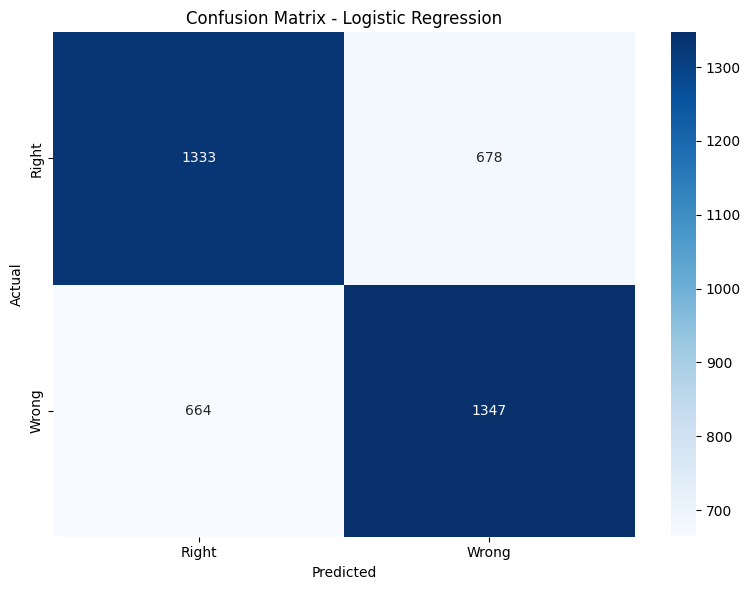


--------------------------------------------------------------------------------
Evaluating Random Forest on Test Set
--------------------------------------------------------------------------------
Test Set Results:
  Accuracy:  0.6566
  Precision: 0.6559
  Recall:    0.6589
  F1-Score:  0.6574

Detailed Classification Report:
              precision    recall  f1-score   support

       Right       0.66      0.65      0.66      2011
       Wrong       0.66      0.66      0.66      2011

    accuracy                           0.66      4022
   macro avg       0.66      0.66      0.66      4022
weighted avg       0.66      0.66      0.66      4022


Confusion Matrix:
                Predicted
                Right  Wrong
Actual Right     1316    695
       Wrong      686   1325


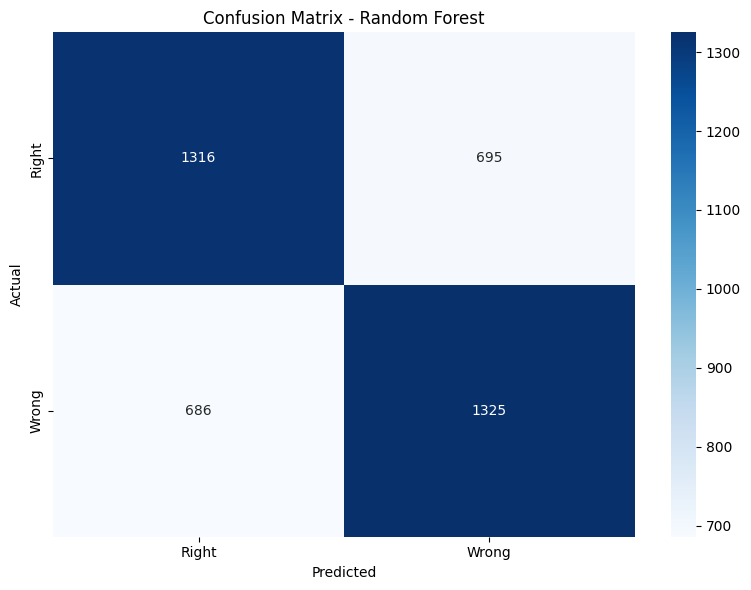


Feature Importance:
                feature  importance
     semantic_coherence    0.212893
        avg_word_length    0.150743
          char_per_word    0.150146
        sentence_length    0.145404
          pos_diversity    0.139677
grammar_oov_interaction    0.098548
              oov_ratio    0.089331
      dep_grammar_score    0.013048
    has_complete_clause    0.000209


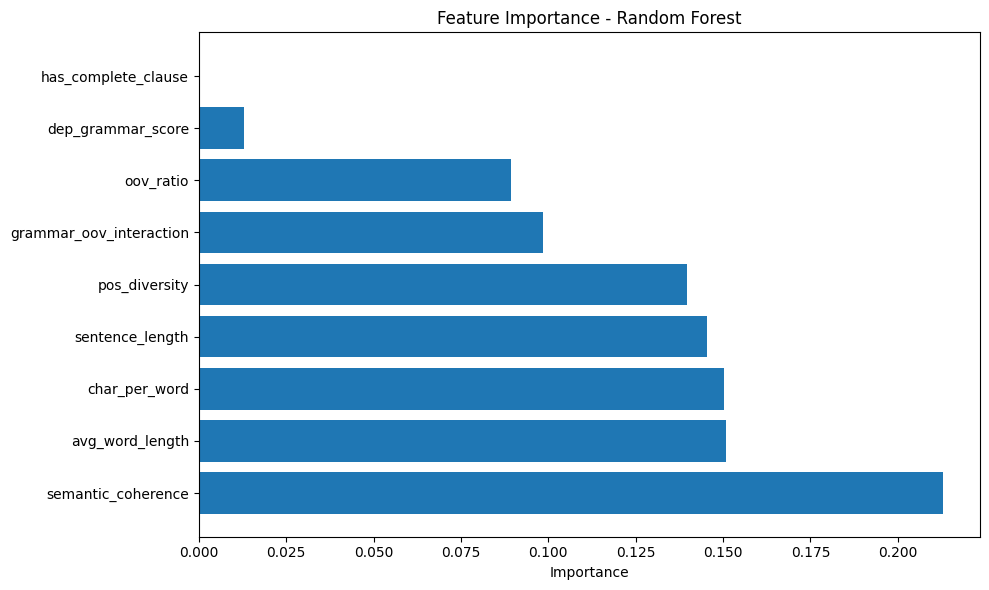


--------------------------------------------------------------------------------
Evaluating Gradient Boosting on Test Set
--------------------------------------------------------------------------------
Test Set Results:
  Accuracy:  0.6783
  Precision: 0.6703
  Recall:    0.7016
  F1-Score:  0.6856

Detailed Classification Report:
              precision    recall  f1-score   support

       Right       0.69      0.65      0.67      2011
       Wrong       0.67      0.70      0.69      2011

    accuracy                           0.68      4022
   macro avg       0.68      0.68      0.68      4022
weighted avg       0.68      0.68      0.68      4022


Confusion Matrix:
                Predicted
                Right  Wrong
Actual Right     1317    694
       Wrong      600   1411


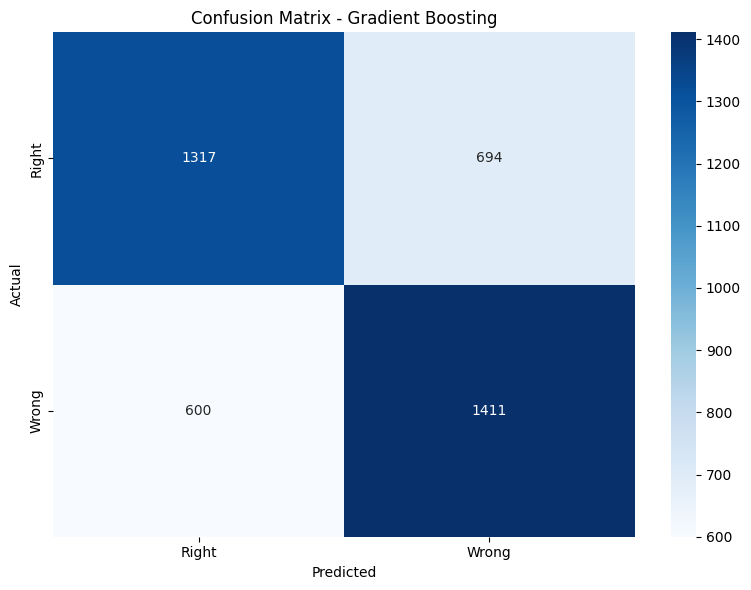


Feature Importance:
                feature  importance
        sentence_length    0.591347
grammar_oov_interaction    0.122300
     semantic_coherence    0.120277
          char_per_word    0.067663
        avg_word_length    0.045824
              oov_ratio    0.021358
          pos_diversity    0.018287
      dep_grammar_score    0.012944
    has_complete_clause    0.000000


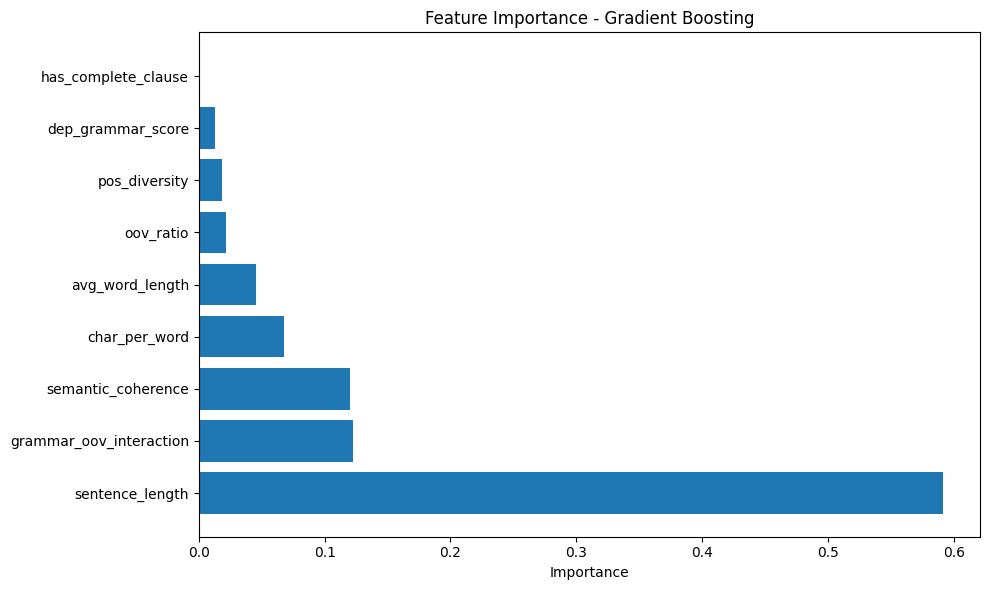


--------------------------------------------------------------------------------
Evaluating Naive Bayes on Test Set
--------------------------------------------------------------------------------
Test Set Results:
  Accuracy:  0.6072
  Precision: 0.5660
  Recall:    0.9194
  F1-Score:  0.7006

Detailed Classification Report:
              precision    recall  f1-score   support

       Right       0.79      0.29      0.43      2011
       Wrong       0.57      0.92      0.70      2011

    accuracy                           0.61      4022
   macro avg       0.68      0.61      0.56      4022
weighted avg       0.68      0.61      0.56      4022


Confusion Matrix:
                Predicted
                Right  Wrong
Actual Right      593   1418
       Wrong      162   1849


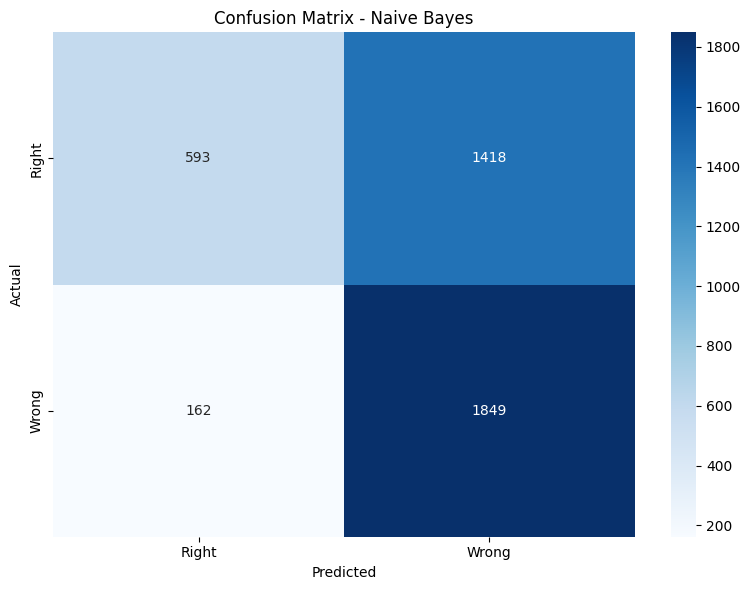


--------------------------------------------------------------------------------
Evaluating LightGBM on Test Set
--------------------------------------------------------------------------------
Test Set Results:
  Accuracy:  0.6740
  Precision: 0.6670
  Recall:    0.6952
  F1-Score:  0.6808

Detailed Classification Report:
              precision    recall  f1-score   support

       Right       0.68      0.65      0.67      2011
       Wrong       0.67      0.70      0.68      2011

    accuracy                           0.67      4022
   macro avg       0.67      0.67      0.67      4022
weighted avg       0.67      0.67      0.67      4022


Confusion Matrix:
                Predicted
                Right  Wrong
Actual Right     1313    698
       Wrong      613   1398


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


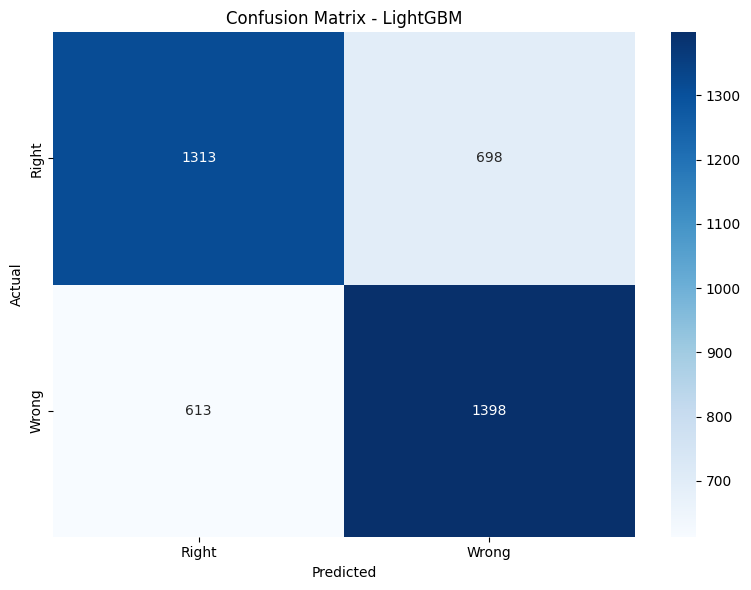


Feature Importance:
                feature  importance
        avg_word_length         725
     semantic_coherence         676
          pos_diversity         445
              oov_ratio         389
        sentence_length         387
grammar_oov_interaction         310
      dep_grammar_score          61
    has_complete_clause           7
          char_per_word           0


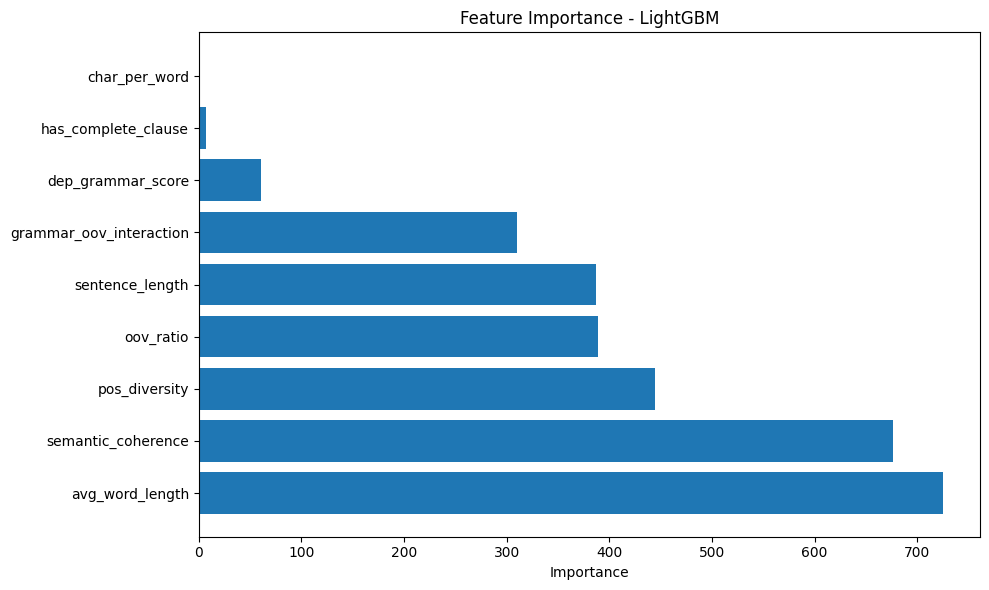


--------------------------------------------------------------------------------
Evaluating SVM on Test Set
--------------------------------------------------------------------------------
Test Set Results:
  Accuracy:  0.6803
  Precision: 0.6722
  Recall:    0.7036
  F1-Score:  0.6876

Detailed Classification Report:
              precision    recall  f1-score   support

       Right       0.69      0.66      0.67      2011
       Wrong       0.67      0.70      0.69      2011

    accuracy                           0.68      4022
   macro avg       0.68      0.68      0.68      4022
weighted avg       0.68      0.68      0.68      4022


Confusion Matrix:
                Predicted
                Right  Wrong
Actual Right     1321    690
       Wrong      596   1415


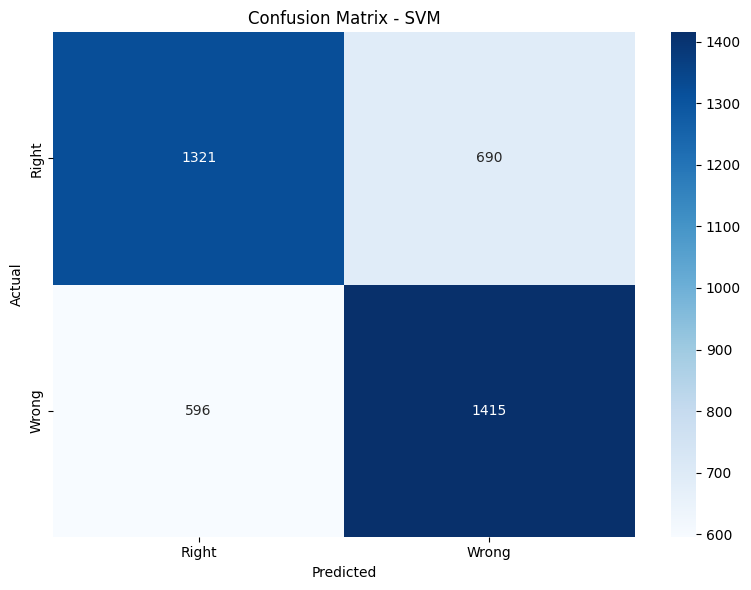

In [ ]:
# Evaluate all baseline models on the test set
print("="*80)
print("Baseline Models Test Set Evaluation")
print("="*80 + "\n")

for name, model_info in results.items():
    model = model_info['model']
    print(f"\n{'-'*80}")
    print(f"Evaluating {name} on Test Set")
    print('-'*80)

    # Predict on test set
    y_test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary')
    test_recall = recall_score(y_test, y_test_pred, average='binary')
    test_f1 = f1_score(y_test, y_test_pred, average='binary')

    print(f"Test Set Results:")
    print(f"  Accuracy:  {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred,
                              target_names=['Right', 'Wrong']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"                Right  Wrong")
    print(f"Actual Right    {cm[0,0]:5d}  {cm[0,1]:5d}")
    print(f"       Wrong    {cm[1,0]:5d}  {cm[1,1]:5d}")

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Right', 'Wrong'],
               yticklabels=['Right', 'Wrong'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Feature importance (only for models that support it, like RandomForest and GradientBoosting)
    if hasattr(model, 'feature_importances_'):
        print("\nFeature Importance:")
        feature_importance = pd.DataFrame({
            'feature': X.columns, # Use X.columns from the original feature df
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print(feature_importance.to_string(index=False))

        # Visualize feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['feature'], feature_importance['importance'])
        plt.xlabel('Importance')
        plt.title(f'Feature Importance - {name}')
        plt.tight_layout()
        plt.savefig(f'feature_importance_{name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
        plt.show()

## LSTM Evaluation

Evaluating LSTM on Test Set


Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]


LSTM Test Results:
  Accuracy:  0.7282
  Precision: 0.7220
  Recall:    0.7424
  F1-Score:  0.7320

Detailed Classification Report:
              precision    recall  f1-score   support

       Right       0.73      0.71      0.72      2011
       Wrong       0.72      0.74      0.73      2011

    accuracy                           0.73      4022
   macro avg       0.73      0.73      0.73      4022
weighted avg       0.73      0.73      0.73      4022


Confusion Matrix:
                Predicted
                Right  Wrong
Actual Right     1436    575
       Wrong      518   1493


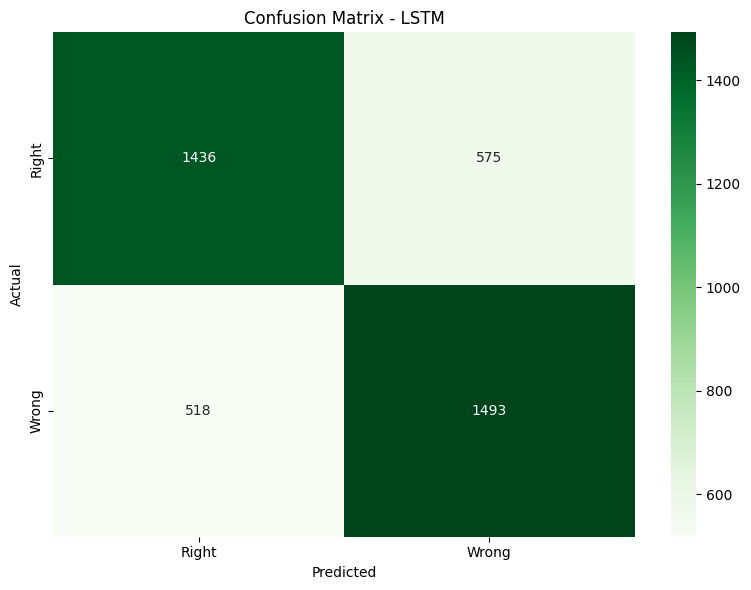

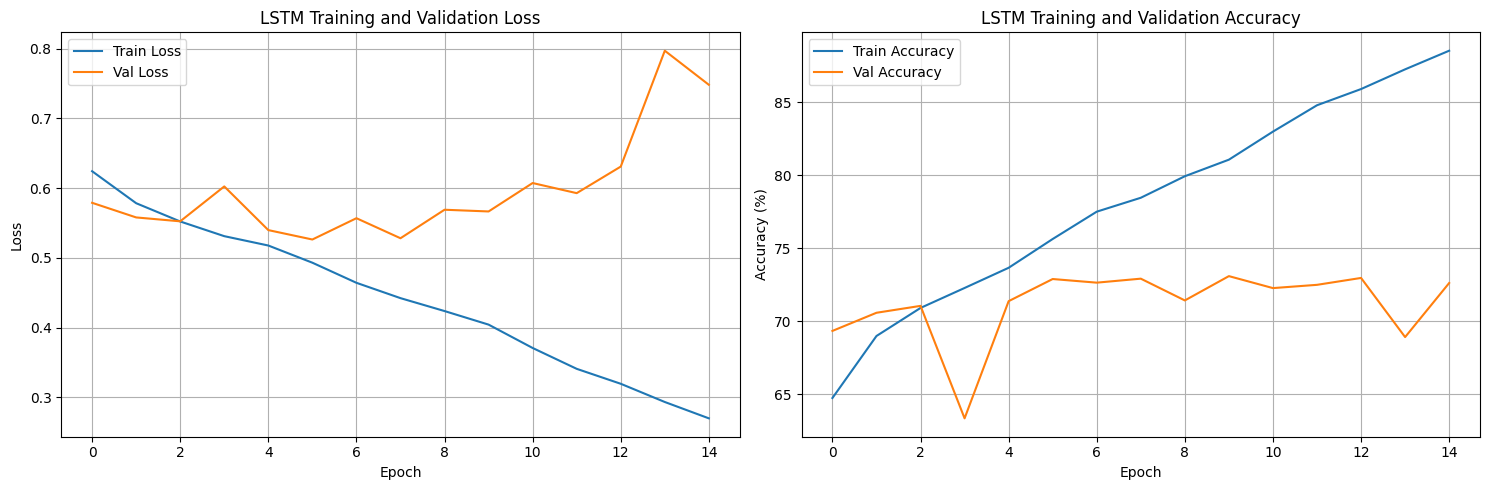

In [ ]:
# Evaluate on test set
print("="*80)
print("Evaluating LSTM on Test Set")
print("="*80)

test_loss, test_acc, y_pred_lstm, y_true_lstm = evaluate_lstm(
    lstm_model, test_loader, criterion, device
)

# Calculate metrics
test_precision = precision_score(y_true_lstm, y_pred_lstm)
test_recall = recall_score(y_true_lstm, y_pred_lstm)
test_f1 = f1_score(y_true_lstm, y_pred_lstm)

print(f"\nLSTM Test Results:")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true_lstm, y_pred_lstm,
                          target_names=['Right', 'Wrong']))

# Confusion matrix
cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"                Right  Wrong")
print(f"Actual Right    {cm_lstm[0,0]:5d}  {cm_lstm[0,1]:5d}")
print(f"       Wrong    {cm_lstm[1,0]:5d}  {cm_lstm[1,1]:5d}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Right', 'Wrong'],
           yticklabels=['Right', 'Wrong'])
plt.title('Confusion Matrix - LSTM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LSTM Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot([acc*100 for acc in train_accs], label='Train Accuracy')
ax2.plot([acc*100 for acc in val_accs], label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LSTM Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('lstm_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Model Testing

In [ ]:
class SentencePredictor:
    """Interface for predicting quality of new sentences"""

    def __init__(self, feature_pipeline_instance, trained_model, scaler, feature_columns, model_type):
        self.feature_pipeline = feature_pipeline_instance
        self.model = trained_model
        self.scaler = scaler
        self.feature_columns = feature_columns
        self.model_type = model_type
        # If LSTM, ensure the model is on the correct device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if self.model_type == 'lstm':
            self.model.to(self.device)


    def extract_features_for_sentence(self, sentence):
        temp_df = pd.DataFrame({'text': [sentence], 'sentence_correct': [0]})

        processed_df = self.feature_pipeline.extract_all_features(temp_df)

        return processed_df

    def predict_sentence(self, sentence):

        # Extract features using the pipeline
        processed_df = self.extract_features_for_sentence(sentence)
        features_dict = processed_df[self.feature_columns].iloc[0].to_dict()
        tokens = processed_df['tokens'].iloc[0]
        pos_tags = processed_df['pos_tags'].iloc[0]

        prediction_numeric = None
        confidence = None
        prediction_label = None

        if self.model_type == 'ml':
            # Get feature values for ML model
            X_new = processed_df[self.feature_columns].values
            X_new_scaled = self.scaler.transform(X_new)

            prediction_numeric = self.model.predict(X_new_scaled)[0]

            # Get probability if available
            if hasattr(self.model, 'predict_proba'):
                proba = self.model.predict_proba(X_new_scaled)[0]
                confidence = proba[prediction_numeric]
            else:
                confidence = 1.0 # Default if no proba information

            # Map numeric prediction to label (0: Correct, 1: Incorrect)
            prediction_label = 'Correct' if prediction_numeric == 0 else 'Incorrect'

        elif self.model_type == 'lstm':
            # Prepare data for LSTM: needs embeddings and padding
            # KhmerTextDataset expects tokens and labels. Use a dummy label.
            temp_lstm_dataset = KhmerTextDataset(
                tokens_list=[tokens],
                labels=[0], # Dummy label
                embedding_model=self.feature_pipeline.embedding_model
            )
            temp_lstm_loader = DataLoader(
                temp_lstm_dataset,
                batch_size=1, # Always batch_size 1 for single sentence prediction
                shuffle=False,
                collate_fn=collate_batch
            )

            self.model.eval() # Set model to evaluation mode
            with torch.no_grad():
                for embeddings, labels, lengths in temp_lstm_loader:
                    embeddings = embeddings.to(self.device)
                    lengths = lengths.to(self.device)

                    outputs = self.model(embeddings, lengths)
                    probabilities = torch.softmax(outputs, dim=1) # Get probabilities for each class
                    confidence_tensor, predicted_class_tensor = torch.max(probabilities, 1) # Get max prob and its index

                    prediction_numeric = predicted_class_tensor.item()
                    confidence = confidence_tensor.item()

            # Map numeric prediction to label (0: Correct, 1: Incorrect)
            prediction_label = 'Correct' if prediction_numeric == 0 else 'Incorrect'

        else:
            raise ValueError(f"Unknown model_type: {self.model_type}")

        return {
            'sentence': sentence,
            'prediction': prediction_label,
            'prediction_numeric': prediction_numeric,
            'confidence': confidence,
            'features': features_dict,
            'tokens': tokens,
            'pos_tags': pos_tags
        }

    def predict_batch(self, sentences):
        """
        Predict quality for multiple sentences at once

        Parameters:
        -----------
        sentences : list of str

        Returns:
        --------
        DataFrame with predictions
        """
        results = []

        for sentence in tqdm(sentences, desc="Predicting"):
            result = self.predict_sentence(sentence)
            results.append({
                'sentence': result['sentence'],
                'prediction': result['prediction'],
                'confidence': result['confidence']
            })

        return pd.DataFrame(results)

In [ ]:
# Determine model type for the best model chosen during baseline evaluation
# If LSTM is chosen, its name needs to be 'LSTM' and best_model needs to be lstm_model
if best_model_name == 'LSTM':
    predictor_model_type = 'lstm'
    predictor_model = lstm_model # Use the trained LSTM model
else:
    predictor_model_type = 'ml'
    predictor_model = best_model # Use the best traditional ML model from results


predictor = SentencePredictor(
    feature_pipeline_instance=feature_pipeline, # Use the already created feature_pipeline instance
    trained_model=predictor_model,
    scaler=scaler, # Use the globally available scaler
    feature_columns=feature_columns, # Use the globally available feature_columns
    model_type=predictor_model_type
)

print(f"✓ Sentence predictor ready!")
print(f"✓ Using model: {best_model_name} ({predictor_model_type.upper()})")
print(f"\nYou can now use: predictor.predict_sentence('your sentence here')")

✓ Sentence predictor ready!
✓ Using model: Naive Bayes (ML)

You can now use: predictor.predict_sentence('your sentence here')


In [ ]:
predictor_model_type = 'lstm'
predictor_model = lstm_model


predictor = SentencePredictor(
    feature_pipeline_instance=feature_pipeline, # Use the already created feature_pipeline instance
    trained_model=predictor_model,
    scaler=scaler, # Use the globally available scaler
    feature_columns=feature_columns, # Use the globally available feature_columns
    model_type=predictor_model_type
)

print(f"✓ Sentence predictor ready!")
print(f"✓ Using model: ({predictor_model_type.upper()})")
print(f"\nYou can now use: predictor.predict_sentence('your sentence here')")

✓ Sentence predictor ready!
✓ Using model: (LSTM)

You can now use: predictor.predict_sentence('your sentence here')


## Test Sentences on NN

In [ ]:
test_sentences = [
    {
        'sentence': "កុមារកម្ពុជាទៅសាលារៀននៅព្រឹកនេះ",
        'expected': 'Correct',
        'description': "Correct: Cambodian children go to school this morning (SVO + time)",
        'complexity': 'Mid'
    },
    {
        'sentence': "ខ្ញុំចង់ញ៉ាំបាយនិងបន្លែជាមួយគ្រួសារ",
        'expected': 'Correct',
        'description': "Correct: I want to eat rice and vegetables with family (compound object)",
        'complexity': 'Mid'
    },
    {
        'sentence': "គាត់ធ្វើការក្នុងក្រុមហ៊ុនធំមួយនៅរាជធានីភ្នំពេញ",
        'expected': 'Correct',
        'description': "Correct: He/She works in a big company in Phnom Penh (complex location)",
        'complexity': 'Mid-High'
    },
    {
        'sentence': "សៀវភៅនេះគឺជារបស់របស់ខ្ញុំដែលទិញពីផ្សារ",
        'expected': 'Correct',
        'description': "Correct: This book is mine that I bought from the market (relative clause)",
        'complexity': 'Mid-High'
    },
    {
        'sentence': "នៅទីនេះដើម្បីរៀនភាសាខ្មែរ",
        'expected': 'Incorrect',
        'description': "Incorrect: Missing subject - 'At here to learn Khmer language' (incomplete)",
        'complexity': 'Mid'
    }
]

print(f"Testing {len(test_sentences)} sentences with varying complexity...\n")
print("Model Type: " + best_model_name + " (" + predictor_model_type.upper() + ")") # Using global variables
print("="*80 + "\n")

# Test each sentence
results_detailed = []
correct_predictions = 0

for idx, test_case in enumerate(test_sentences, 1):
    print(f"{'='*80}")
    print(f"TEST {idx}/{len(test_sentences)}")
    print(f"{'='*80}")
    print(f"📝 Sentence: {test_case['sentence']}")
    print(f"📋 Description: {test_case['description']}")
    print(f"⚙️  Complexity: {test_case['complexity']}")
    print(f"✓ Expected: {test_case['expected']}")
    print()

    # Get prediction
    result = predictor.predict_sentence(test_case['sentence'])

    # Display results
    print(f"🤖 PREDICTION RESULTS:")
    print(f"   Prediction: {result['prediction']}")
    print(f"   Confidence: {result['confidence']:.2%}")
    print(f"   Status: {'✅ CORRECT' if result['prediction'] == test_case['expected'] else '❌ WRONG'}")

    # Show key features
    print(f"\n📊 Key Feature Values:")
    print(f"   dep_grammar_score:        {result['features']['dep_grammar_score']:.3f}")
    print(f"   has_complete_clause:      {result['features']['has_complete_clause']}")
    print(f"   oov_ratio:                {result['features']['oov_ratio']:.3f}")
    print(f"   semantic_coherence:       {result['features']['semantic_coherence']:.3f}")
    print(f"   grammar_oov_interaction:  {result['features']['grammar_oov_interaction']:.3f}")

    # Show tokenization
    print(f"\n🔤 Tokens ({len(result['tokens'])} words):")
    print(f"   {' | '.join(result['tokens'])}")

    print(f"\n🏷️  POS Tags:")
    print(f"   {' | '.join(result['pos_tags'])}")

    print()

    # Track accuracy
    if result['prediction'] == test_case['expected']:
        correct_predictions += 1

    # Store for summary
    results_detailed.append({
        'sentence': test_case['sentence'],
        'expected': test_case['expected'],
        'predicted': result['prediction'],
        'confidence': result['confidence'],
        'correct': result['prediction'] == test_case['expected'],
        'grammar_score': result['features']['dep_grammar_score'],
        'oov_ratio': result['features']['oov_ratio']
    })

# Summary statistics
print("\n" + "="*80)
print("TESTING SUMMARY")
print("="*80)
print(f"\n📈 Overall Accuracy: {correct_predictions}/{len(test_sentences)} ({correct_predictions/len(test_sentences)*100:.1f}%)")
print(f"✅ Correct Predictions: {correct_predictions}")
print(f"❌ Wrong Predictions: {len(test_sentences) - correct_predictions}")
print(f"\n🎯 Average Confidence: {np.mean([r['confidence'] for r in results_detailed]):.2%}")

# Create summary table
summary_df = pd.DataFrame(results_detailed)
print(f"\n📊 Detailed Results Table:")
print("="*80)
display(summary_df)

Testing 5 sentences with varying complexity...

Model Type: Naive Bayes (LSTM)

TEST 1/5
📝 Sentence: កុមារកម្ពុជាទៅសាលារៀននៅព្រឹកនេះ
📋 Description: Correct: Cambodian children go to school this morning (SVO + time)
⚙️  Complexity: Mid
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.000
  Mean vocab coverage: 1.000
  Median OOV ratio: 0.000
  Max OOV ratio: 0.000
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.238
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 100.00%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.000
   semantic_coherence:       0.238
   grammar_oov_interaction:  1.000

🔤 Tokens (8 words):
   កុមារ | កម្ពុជា | ទៅ | សាលា | រៀន | នៅ | ព្រឹក | នេះ

🏷️  POS Tags:
   NN | PN | VB | NN | VB | IN | NN | DT

TEST 2/5
📝 Sentence: ខ្ញុំចង់ញ៉ាំបាយនិងបន្លែជាមួយគ្រួសារ
📋 Description: Correct: I want to eat rice and vegetables with family (compound object)
⚙️  Complexity: Mid
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.143
  Mean vocab coverage: 0.857
  Median OOV ratio: 0.143
  Max OOV ratio: 0.143
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.233
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 100.00%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.143
   semantic_coherence:       0.233
   grammar_oov_interaction:  0.857

🔤 Tokens (7 words):
   ខ្ញុំ | ចង់ញ៉ាំ | បាយ | និង | បន្លែ | ជាមួយ | គ្រួសារ

🏷️  POS Tags:
   PRO | VB | NN | CC | NN | IN | NN

TEST 3/5
📝 Sentence: គាត់ធ្វើការក្នុងក្រុមហ៊ុនធំមួយនៅរាជធានីភ្នំពេញ
📋 Description: Correct: He/She works in a big company in Phnom Penh (complex location)
⚙️  Complexity: Mid-High
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.125
  Mean vocab coverage: 0.875
  Median OOV ratio: 0.125
  Max OOV ratio: 0.125
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 0.800
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.240
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 99.92%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        0.800
   has_complete_clause:      1.0
   oov_ratio:                0.125
   semantic_coherence:       0.240
   grammar_oov_interaction:  0.700

🔤 Tokens (8 words):
   គាត់ | ធ្វើការ | ក្នុង | ក្រុមហ៊ុន | ធំ | មួយ | នៅ | រាជធានីភ្នំពេញ

🏷️  POS Tags:
   PRO | VB | IN | NN | JJ | DT | IN | PN

TEST 4/5
📝 Sentence: សៀវភៅនេះគឺជារបស់របស់ខ្ញុំដែលទិញពីផ្សារ
📋 Description: Correct: This book is mine that I bought from the market (relative clause)
⚙️  Complexity: Mid-High
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.000
  Mean vocab coverage: 1.000
  Median OOV ratio: 0.000
  Max OOV ratio: 0.000
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.350
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 99.99%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.000
   semantic_coherence:       0.350
   grammar_oov_interaction:  1.000

🔤 Tokens (10 words):
   សៀវភៅ | នេះ | គឺជា | របស់ | របស់ | ខ្ញុំ | ដែល | ទិញ | ពី | ផ្សារ

🏷️  POS Tags:
   NN | DT | VB | NN | IN | PRO | RPN | VB | IN | NN

TEST 5/5
📝 Sentence: នៅទីនេះដើម្បីរៀនភាសាខ្មែរ
📋 Description: Incorrect: Missing subject - 'At here to learn Khmer language' (incomplete)
⚙️  Complexity: Mid
✓ Expected: Incorrect

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.000
  Mean vocab coverage: 1.000
  Median OOV ratio: 0.000
  Max OOV ratio: 0.000
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.318
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 100.00%
   Status: ❌ WRONG

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.000
   semantic_coherence:       0.318
   grammar_oov_interaction:  1.000

🔤 Tokens (7 words):
   នៅ | ទី | នេះ | ដើម្បី | រៀន | ភាសា | ខ្មែរ

🏷️  POS Tags:
   IN | NN | DT | IN | VB | NN | PN


TESTING SUMMARY

📈 Overall Accuracy: 4/5 (80.0%)
✅ Correct Predictions: 4
❌ Wrong Predictions: 1

🎯 Average Confidence: 99.98%

📊 Detailed Results Table:


,sentence,expected,predicted,confidence,correct,grammar_score,oov_ratio
0,កុមារកម្ពុជាទៅសាលារៀននៅព្រឹកនេះ,Correct,Correct,0.999993,True,1.0,0.000000
1,ខ្ញុំចង់ញ៉ាំបាយនិងបន្លែជាមួយគ្រួសារ,Correct,Correct,0.999983,True,1.0,0.142857
2,គាត់ធ្វើការក្នុងក្រុមហ៊ុនធំមួយនៅរាជធានីភ្នំពេញ,Correct,Correct,0.999171,True,0.8,0.125000
3,សៀវភៅនេះគឺជារបស់របស់ខ្ញុំដែលទិញពីផ្សារ,Correct,Correct,0.999869,True,1.0,0.000000
4,នៅទីនេះដើម្បីរៀនភាសាខ្មែរ,Incorrect,Correct,0.999991,False,1.0,0.000000


## Test Setences on ML

In [ ]:
test_sentences = [
    {
        'sentence': "កុមារកម្ពុជាទៅសាលារៀននៅព្រឹកនេះ",
        'expected': 'Correct',
        'description': "Correct: Cambodian children go to school this morning (SVO + time)",
        'complexity': 'Mid'
    },
    {
        'sentence': "ខ្ញុំចង់ញ៉ាំបាយនិងបន្លែជាមួយគ្រួសារ",
        'expected': 'Correct',
        'description': "Correct: I want to eat rice and vegetables with family (compound object)",
        'complexity': 'Mid'
    },
    {
        'sentence': "គាត់ធ្វើការក្នុងក្រុមហ៊ុនធំមួយនៅរាជធានីភ្នំពេញ",
        'expected': 'Correct',
        'description': "Correct: He/She works in a big company in Phnom Penh (complex location)",
        'complexity': 'Mid-High'
    },
    {
        'sentence': "សៀវភៅនេះគឺជារបស់របស់ខ្ញុំដែលទិញពីផ្សារ",
        'expected': 'Correct',
        'description': "Correct: This book is mine that I bought from the market (relative clause)",
        'complexity': 'Mid-High'
    },
    {
        'sentence': "នៅទីនេះដើម្បីរៀនភាសាខ្មែរ",
        'expected': 'Incorrect',
        'description': "Incorrect: Missing subject - 'At here to learn Khmer language' (incomplete)",
        'complexity': 'Mid'
    }
]

print(f"Testing {len(test_sentences)} sentences with varying complexity...\n")
print("Model Type: " + best_model_name + " (" + predictor_model_type.upper() + ")")
print("="*80 + "\n")

# Test each sentence
results_detailed = []
correct_predictions = 0

for idx, test_case in enumerate(test_sentences, 1):
    print(f"{'='*80}")
    print(f"TEST {idx}/{len(test_sentences)}")
    print(f"{'='*80}")
    print(f"📝 Sentence: {test_case['sentence']}")
    print(f"📋 Description: {test_case['description']}")
    print(f"⚙️  Complexity: {test_case['complexity']}")
    print(f"✓ Expected: {test_case['expected']}")
    print()

    # Get prediction
    result = predictor.predict_sentence(test_case['sentence'])

    # Display results
    print(f"🤖 PREDICTION RESULTS:")
    print(f"   Prediction: {result['prediction']}")
    print(f"   Confidence: {result['confidence']:.2%}")
    print(f"   Status: {'✅ CORRECT' if result['prediction'] == test_case['expected'] else '❌ WRONG'}")

    # Show key features
    print(f"\n📊 Key Feature Values:")
    print(f"   dep_grammar_score:        {result['features']['dep_grammar_score']:.3f}")
    print(f"   has_complete_clause:      {result['features']['has_complete_clause']}")
    print(f"   oov_ratio:                {result['features']['oov_ratio']:.3f}")
    print(f"   semantic_coherence:       {result['features']['semantic_coherence']:.3f}")
    print(f"   grammar_oov_interaction:  {result['features']['grammar_oov_interaction']:.3f}")

    # Show tokenization
    print(f"\n🔤 Tokens ({len(result['tokens'])} words):")
    print(f"   {' | '.join(result['tokens'])}")

    print(f"\n🏷️  POS Tags:")
    print(f"   {' | '.join(result['pos_tags'])}")

    print()

    # Track accuracy
    if result['prediction'] == test_case['expected']:
        correct_predictions += 1

    # Store for summary
    results_detailed.append({
        'sentence': test_case['sentence'],
        'expected': test_case['expected'],
        'predicted': result['prediction'],
        'confidence': result['confidence'],
        'correct': result['prediction'] == test_case['expected'],
        'grammar_score': result['features']['dep_grammar_score'],
        'oov_ratio': result['features']['oov_ratio']
    })

# Summary statistics
print("\n" + "="*80)
print("TESTING SUMMARY")
print("="*80)
print(f"\n📈 Overall Accuracy: {correct_predictions}/{len(test_sentences)} ({correct_predictions/len(test_sentences)*100:.1f}%)")
print(f"✅ Correct Predictions: {correct_predictions}")
print(f"❌ Wrong Predictions: {len(test_sentences) - correct_predictions}")
print(f"\n🎯 Average Confidence: {np.mean([r['confidence'] for r in results_detailed]):.2%}")

# Create summary table
summary_df = pd.DataFrame(results_detailed)
print(f"\n📊 Detailed Results Table:")
print("="*80)
display(summary_df)

Testing 5 sentences with varying complexity...

Model Type: Naive Bayes (LSTM)

TEST 1/5
📝 Sentence: កុមារកម្ពុជាទៅសាលារៀននៅព្រឹកនេះ
📋 Description: Correct: Cambodian children go to school this morning (SVO + time)
⚙️  Complexity: Mid
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.000
  Mean vocab coverage: 1.000
  Median OOV ratio: 0.000
  Max OOV ratio: 0.000
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.238
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 100.00%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.000
   semantic_coherence:       0.238
   grammar_oov_interaction:  1.000

🔤 Tokens (8 words):
   កុមារ | កម្ពុជា | ទៅ | សាលា | រៀន | នៅ | ព្រឹក | នេះ

🏷️  POS Tags:
   NN | PN | VB | NN | VB | IN | NN | DT

TEST 2/5
📝 Sentence: ខ្ញុំចង់ញ៉ាំបាយនិងបន្លែជាមួយគ្រួសារ
📋 Description: Correct: I want to eat rice and vegetables with family (compound object)
⚙️  Complexity: Mid
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.143
  Mean vocab coverage: 0.857
  Median OOV ratio: 0.143
  Max OOV ratio: 0.143
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.233
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 100.00%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.143
   semantic_coherence:       0.233
   grammar_oov_interaction:  0.857

🔤 Tokens (7 words):
   ខ្ញុំ | ចង់ញ៉ាំ | បាយ | និង | បន្លែ | ជាមួយ | គ្រួសារ

🏷️  POS Tags:
   PRO | VB | NN | CC | NN | IN | NN

TEST 3/5
📝 Sentence: គាត់ធ្វើការក្នុងក្រុមហ៊ុនធំមួយនៅរាជធានីភ្នំពេញ
📋 Description: Correct: He/She works in a big company in Phnom Penh (complex location)
⚙️  Complexity: Mid-High
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.125
  Mean vocab coverage: 0.875
  Median OOV ratio: 0.125
  Max OOV ratio: 0.125
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 0.800
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.240
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 99.92%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        0.800
   has_complete_clause:      1.0
   oov_ratio:                0.125
   semantic_coherence:       0.240
   grammar_oov_interaction:  0.700

🔤 Tokens (8 words):
   គាត់ | ធ្វើការ | ក្នុង | ក្រុមហ៊ុន | ធំ | មួយ | នៅ | រាជធានីភ្នំពេញ

🏷️  POS Tags:
   PRO | VB | IN | NN | JJ | DT | IN | PN

TEST 4/5
📝 Sentence: សៀវភៅនេះគឺជារបស់របស់ខ្ញុំដែលទិញពីផ្សារ
📋 Description: Correct: This book is mine that I bought from the market (relative clause)
⚙️  Complexity: Mid-High
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.000
  Mean vocab coverage: 1.000
  Median OOV ratio: 0.000
  Max OOV ratio: 0.000
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.350
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 99.99%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.000
   semantic_coherence:       0.350
   grammar_oov_interaction:  1.000

🔤 Tokens (10 words):
   សៀវភៅ | នេះ | គឺជា | របស់ | របស់ | ខ្ញុំ | ដែល | ទិញ | ពី | ផ្សារ

🏷️  POS Tags:
   NN | DT | VB | NN | IN | PRO | RPN | VB | IN | NN

TEST 5/5
📝 Sentence: នៅទីនេះដើម្បីរៀនភាសាខ្មែរ
📋 Description: Incorrect: Missing subject - 'At here to learn Khmer language' (incomplete)
⚙️  Complexity: Mid
✓ Expected: Incorrect

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.000
  Mean vocab coverage: 1.000
  Median OOV ratio: 0.000
  Max OOV ratio: 0.000
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.318
✓ Interaction features extracted
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 100.00%
   Status: ❌ WRONG

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.000
   semantic_coherence:       0.318
   grammar_oov_interaction:  1.000

🔤 Tokens (7 words):
   នៅ | ទី | នេះ | ដើម្បី | រៀន | ភាសា | ខ្មែរ

🏷️  POS Tags:
   IN | NN | DT | IN | VB | NN | PN


TESTING SUMMARY

📈 Overall Accuracy: 4/5 (80.0%)
✅ Correct Predictions: 4
❌ Wrong Predictions: 1

🎯 Average Confidence: 99.98%

📊 Detailed Results Table:


,sentence,expected,predicted,confidence,correct,grammar_score,oov_ratio
0,កុមារកម្ពុជាទៅសាលារៀននៅព្រឹកនេះ,Correct,Correct,0.999993,True,1.0,0.000000
1,ខ្ញុំចង់ញ៉ាំបាយនិងបន្លែជាមួយគ្រួសារ,Correct,Correct,0.999983,True,1.0,0.142857
2,គាត់ធ្វើការក្នុងក្រុមហ៊ុនធំមួយនៅរាជធានីភ្នំពេញ,Correct,Correct,0.999171,True,0.8,0.125000
3,សៀវភៅនេះគឺជារបស់របស់ខ្ញុំដែលទិញពីផ្សារ,Correct,Correct,0.999869,True,1.0,0.000000
4,នៅទីនេះដើម្បីរៀនភាសាខ្មែរ,Incorrect,Correct,0.999991,False,1.0,0.000000
